In [93]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from joblib import dump, load
from sklearn.preprocessing import OneHotEncoder


In [94]:
test_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_test.csv")
train_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_train.csv")

# Analysera datan

In [95]:
train_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [96]:
train_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


### Finns dubbletter?

In [97]:
print(f'***Train_churn***\n{train_churn.duplicated().value_counts()}')

***Train_churn***
False    5634
dtype: int64


### Saknas värden?

In [98]:
print(f'***Train_churn***\n{train_churn.isna().sum()}')

***Train_churn***
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Hur ser fördelningen av target datan ut? Är den jämt fördelad? Om inte, kan det ställa till med problem?

Customers who stayed:   4148
Customers who churned:   1486


Text(0, 0.5, 'Count')

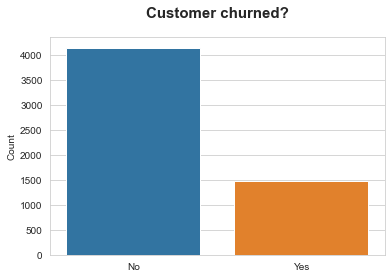

In [99]:
target_dist = train_churn['Churn'].value_counts()
print('Customers who stayed:  ', target_dist[0])
print('Customers who churned:  ', target_dist[1])


# Visualize the customer churn distribution
sns.set_style('whitegrid')
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Customer churned?', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Count')

Det är uppenbart att det inte jämt fördelad det är klassobalans i vår datauppsättning eftersom det är typ 26,5 % av kunderna churnade medan 73,5 % av kunderna stannade.
om det kan ställa till med problem,ja eftersom Eftersom beslutsträdsbaserade modeller som XGBoost är mottagliga för frekvens datapunkter, därför måste vi göra med klassobalansen på ett av två sätt för att göra fördelningen mer lika

##  Förbered datan för att kunna användas av modellen

In [100]:
train_churn['TotalCharges'].apply(type).value_counts()

<class 'str'>    5634
Name: TotalCharges, dtype: int64

In [101]:

# Function to check if a string can be converted to a float
def is_convertible(value):
    """
    Checks to see whether a string can be converted to a float.
    Input:
        - A string
    Output:
        - A boolean indicating whether or not the string can be converted to a float
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

    
    
# Initialize list of strings that can't be converted to a float
unconvertibles = []

# Iterate through an array of strings, and append unconvertible strings to a list
str_array = train_churn['TotalCharges'].to_numpy()
for element in str_array:
    if is_convertible(element) == False:
        unconvertibles.append(element)

# See which strings (if any) are unconvertible
print("Unconvertibles:  ", unconvertibles)
print("Count of unconvertibles:  ", len(unconvertibles))

Unconvertibles:   [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Count of unconvertibles:   8


In [102]:
# Convert from 'object' to 'float' while replacing strings containing whitespace with NaN
train_churn['TotalCharges'] = pd.to_numeric(train_churn['TotalCharges'], errors='coerce')

In [103]:
train_churn.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5634.000000,5634.000000,5634.000000,5626.000000
mean,0.162052,32.651757,64.828852,2303.264833
std,0.368531,24.568438,30.187464,2270.600082
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.462500,411.375000
50%,0.000000,29.000000,70.400000,1422.850000
75%,0.000000,56.000000,90.050000,3823.762500
max,1.000000,72.000000,118.750000,8684.800000


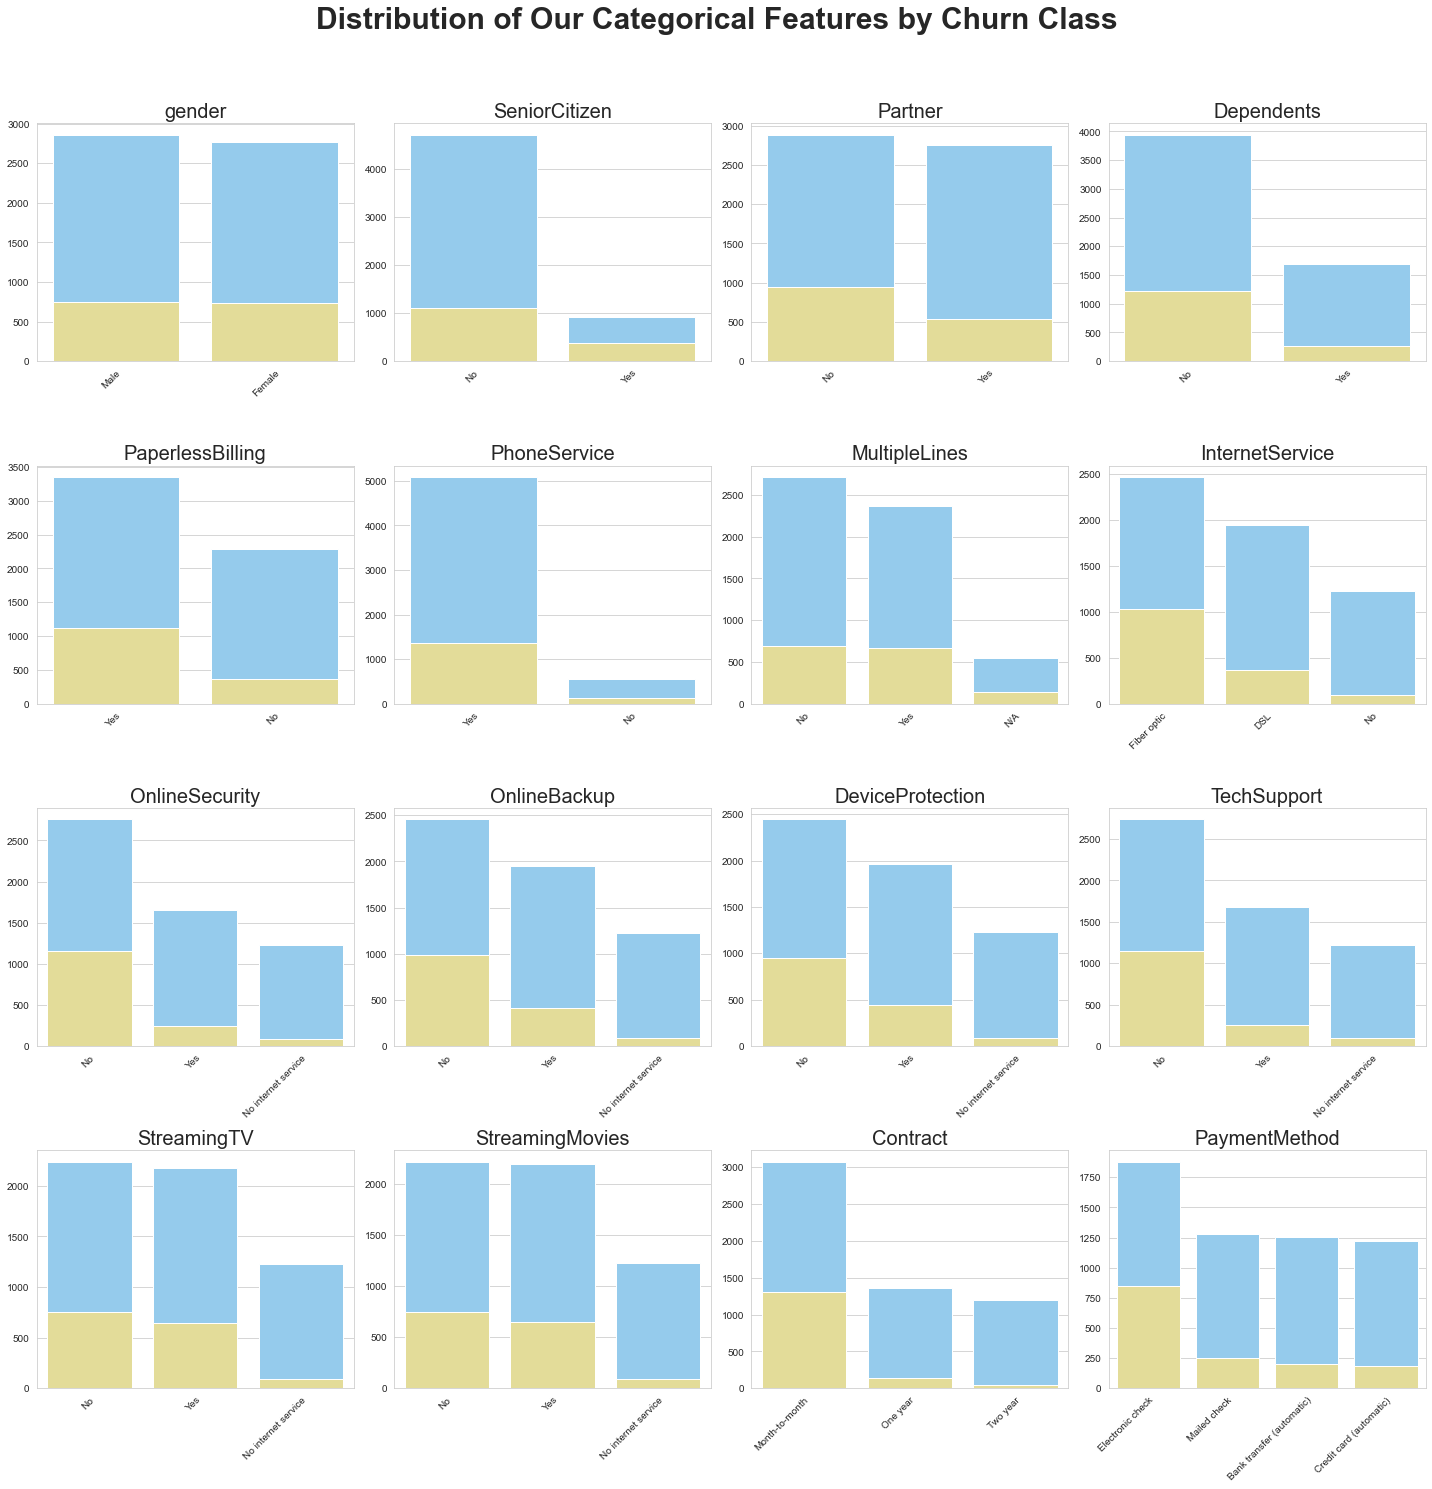

In [104]:
# Find and replace categorical values to make visualization more readable
train_churn['SeniorCitizen'].astype('object')
train_churn.replace(to_replace={'SeniorCitizen': {0:'No', 1:'Yes'}}, inplace=True)
train_churn.replace(to_replace={'MultipleLines': {'No phone service':'N/A'}}, inplace=True)

# Get a list of attributes to visualize
cat_cols_viz = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'PaperlessBilling', 'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


# Set style
sns.set_style('whitegrid')

# Set up subplot to display graphs
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=False, sharey=False)
plt.suptitle('Distribution of Our Categorical Features by Churn Class', 
             fontsize=30, fontweight='bold', y=1.032)

# Initialize row and column index iterators in preparation for filling in the subplot
row_iterator = 0
col_iterator = 0

# Fill in the subplot
for col in cat_cols_viz:
    # Adjust indices once we reach the end of a row (moving from left to right)
    if col_iterator == 4:
        col_iterator = 0
        row_iterator = row_iterator + 1
    
    
    # Initialize value count series
    valCount_series = train_churn[col].value_counts()
    churn_valCount_series = train_churn[train_churn.Churn=='Yes'][col].value_counts()
    
    
    # Create the barplot (in blue) depicting customer count--by column
    sns.barplot(x=valCount_series.index, y=valCount_series.values, color='lightskyblue', ax=axes[row_iterator][col_iterator])
    
    # Create the barplot (in orange) depicting customer churn count--by column
    sns.barplot(x=churn_valCount_series.index, y=churn_valCount_series.values, color='khaki', ax=axes[row_iterator][col_iterator])

    # Label the graph
    axes[row_iterator][col_iterator].set_title('%s' % col, fontsize=20)
        
    # Rotate xlabels
    plt.sca(axes[row_iterator, col_iterator])
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')    
    
    # Increment row and column indices
    col_iterator = col_iterator + 1

    
# Adjust spacing of subplot
fig.tight_layout()

In [105]:
# Check how many 0's are found within 'TotalCharges'
totCharges_zeroes = train_churn[train_churn['TotalCharges'] == 0].shape[0]
print('There are  ', totCharges_zeroes, "  representations of '0' found within 'TotalCharges'")

There are   0   representations of '0' found within 'TotalCharges'


In [106]:
# Drop the 'gender' column from our dataset since it doesn't contribute to our model
train_churn = train_churn.drop('gender', axis=1)

# Remove whitespace from value classes and replace with '_'
whitespace_cols = cat_cols_viz[7:]
train_churn[whitespace_cols] = train_churn[whitespace_cols].stack().str.replace(' ', '_').unstack()

# Make value classes more descriptive
train_churn.replace(to_replace={'SeniorCitizen': {'No':'Not_SenCit', 'Yes':'SeniorCitizen'}}, inplace=True)
train_churn.replace(to_replace={'Partner': {'No':'No_Partner', 'Yes':'Partner'}}, inplace=True)
train_churn.replace(to_replace={'Dependents': {'No':'No_Dependents', 'Yes':'Dependents'}}, inplace=True)
train_churn.replace(to_replace={'PaperlessBilling': {'No':'No_PaperlessBill', 'Yes':'PaperlessBill'}}, inplace=True)
train_churn.replace(to_replace={'PhoneService': {'No':'No_PhoneService', 'Yes':'PhoneService'}}, inplace=True)
train_churn.replace(to_replace={'MultipleLines': {'No':'No_MultiLines', 'Yes':'MultiLines', 'N/A': 'No_PhoneService'}}, inplace=True)
train_churn.replace(to_replace={'InternetService': {'No':'No_internet_service'}}, inplace=True)
train_churn.replace(to_replace={'OnlineSecurity': {'No':'No_OnlineSecurity', 'Yes':'OnlineSecurity'}}, inplace=True)
train_churn.replace(to_replace={'OnlineBackup': {'No':'No_OnlineBackup', 'Yes':'OnlineBackup'}}, inplace=True)
train_churn.replace(to_replace={'DeviceProtection': {'No':'No_DeviceProtection', 'Yes':'DeviceProtection'}}, inplace=True)
train_churn.replace(to_replace={'TechSupport': {'No':'No_TechSupport', 'Yes':'TechSupport'}}, inplace=True)
train_churn.replace(to_replace={'StreamingTV': {'No':'No_StreamingTV', 'Yes':'StreamingTV'}}, inplace=True)
train_churn.replace(to_replace={'StreamingMovies': {'No':'No_StreamingMov', 'Yes':'StreamingMov'}}, inplace=True)

# Using 'customerID', check to see if there are any duplicate entries
print('Number of duplicate entries:  ', X.index.duplicated().sum())

Number of duplicate entries:   0


In [107]:

# DataFrame of customers whose 'TotalCharges' was the empty string
totCharges_nan = train_churn[train_churn['TotalCharges'].isnull()]

# Find how many customers there are whose 'TotalCharges' was the empty string
print("There are ", totCharges_nan.shape[0], " customers whose 'TotalCharges' was the empty string")

# Get average 'tenure' of customers whose 'TotalCharges' was the empty string
print("The average TENURE of this subset is:  ", 
      totCharges_nan['tenure'].mean())

# Get average 'MonthlyCharges' for customers whose 'TotalCharges' was the empty string
print("The average MONTHLY CHARGE of this subset is:  ", 
      totCharges_nan['MonthlyCharges'].mean())

# Check if any customers whose 'TotalCharges' was the empty string had a monthly charge of 0
print('Did any such customers have a monthly charge of 0?    ', 0 in totCharges_nan['MonthlyCharges'].values)

There are  8  customers whose 'TotalCharges' was the empty string
The average TENURE of this subset is:   0.0
The average MONTHLY CHARGE of this subset is:   30.66875
Did any such customers have a monthly charge of 0?     False


In [108]:
# Find and replace NaN with 0 in 'TotalCharges'
train_churn.fillna({'TotalCharges': 0}, inplace=True)

In [109]:
# Generate new features by combining existing ones
train_churn['SenCit_Dependents'] = train_churn['SeniorCitizen'] + '_' + train_churn['Dependents']
train_churn['Partner_Dependents'] = train_churn['Partner'] + '_' + train_churn['Dependents']
train_churn['SenCit_Partner'] = train_churn['SeniorCitizen'] + '_' + train_churn['Partner']
train_churn['SenCit_Contract'] = train_churn['SeniorCitizen'] + '_' + train_churn['Contract']
train_churn['SenCit_TechSupport'] = train_churn['SeniorCitizen'] + '_' + train_churn['TechSupport']
train_churn['SenCit_PayMeth'] = train_churn['SeniorCitizen'] + '_' + train_churn['PaymentMethod']

In [110]:
# Create column giving the average of 'TotalCharges' by contract length
temp1 = train_churn.groupby('Contract')['TotalCharges'].agg(['mean']).rename({'mean':'Contract_mean_totCharges'},axis=1)
train_churn = pd.merge(train_churn, temp1, on='Contract', how='left')

# Create column giving the difference in 'TotalCharges' and the average of 'TotalCharges' by contract length
train_churn['Contract_totCharges_diff'] = train_churn['TotalCharges'] - train_churn['Contract_mean_totCharges']


# Create column giving the average of 'MonthlyCharges' by payment method
temp2 = train_churn.groupby('PaymentMethod')['MonthlyCharges'].agg(['mean']).rename({'mean':'PayMeth_mean_monthCharges'},axis=1)
train_churn = pd.merge(train_churn, temp2, on='PaymentMethod', how='left')

# Create column giving the difference in 'MonthlyCharges' and the average of 'MonthlyCharges' by payment method
train_churn['PayMeth_monthCharges_diff'] = train_churn['MonthlyCharges'] - train_churn['PayMeth_mean_monthCharges']

In [111]:
train_churn = train_churn.round(2)


In [112]:
### Ordinal Encoding

# Ordinal encoding of 'MultipleLines'
multiLines_dict = {'No_PhoneService':0, 'No_MultiLines':1, 'MultiLines':2}
train_churn['MultipleLines_Ordinal'] = train_churn['MultipleLines'].map(multiLines_dict)

# Ordinal encoding of 'InternetService'
intServ_dict = {'No_internet_service':0, 'DSL':1, 'Fiber_optic':2}
train_churn['InternetService_Ordinal'] = train_churn['InternetService'].map(intServ_dict)

# Ordinal encoding of 'Contract'
contract_dict = {'Month-to-month':0, 'One_year':1, 'Two_year':2}
train_churn['Contract_Ordinal'] = train_churn['Contract'].map(contract_dict)

# Drop unnecessary columns that have been encoded
ordinal_drop_cols = ['MultipleLines', 'InternetService', 'Contract']
train_churn.drop(ordinal_drop_cols, axis=1, inplace=True)

In [113]:
### One-hot Encoding

# Apply one-hot encoder to the relevant columns
OH_col_names = ['SeniorCitizen', 'Partner', 'Dependents', 
           'PaperlessBilling', 'PhoneService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'PaymentMethod',
           'SenCit_Dependents', 'Partner_Dependents', 'SenCit_Partner',
           'SenCit_Contract', 'SenCit_TechSupport', 'SenCit_PayMeth']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(train_churn[OH_col_names]))

# Replace default column names with more descriptive ones
OH_cols.columns = OH_encoder.get_feature_names(OH_col_names)

# One-hot encoding removed index; put it back
OH_cols.index = train_churn.index

# Remove categorical columns (will replace with one-hot encoding)
train_churn.drop(OH_col_names, axis=1, inplace=True)

# Add one-hot encoded columns to numerical features
train_churn = pd.concat([train_churn, OH_cols], axis=1)

In [118]:
from imblearn.over_sampling import SMOTE

# # Oversample our dataset using SMOTE to deal with class imbalance
# oversample = SMOTE(sampling_strategy=0.5, random_state=42)
# X, y = oversample.fit_resample(X, y)

AttributeError: module 'sklearn.utils._openmp_helpers' has no attribute '__pyx_capi__'